In [228]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [360]:
#chroms = [str(x) for x in range(1, 23)]
chroms = ['22']
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart_strict'
ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc_strict'

In [361]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [362]:
print(Counter([len(v) for v in fam_to_inds.values()]))
print(list(fam_to_inds.keys())[:5])

Counter({4: 2500, 5: 421, 3: 258, 6: 69, 7: 13, 9: 4, 10: 1, 8: 1})
['AU0005.0.0', 'AU0005.AU000501.AU000502', 'AU0012.0.0', 'AU0012.AU001201.AU001202', 'AU0020.0.0']


# Filter Families


In [363]:
def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
    

In [364]:
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

22 Families with all chroms 781
Counter({1: 781})
22 Families with all chroms 321
Counter({1: 321})


# Read in deletions

In [365]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'length',
                                   'trans', 'notrans',
                                   'is_mat', 'is_pat', 'mother', 'father', 'mother_gen', 'father_gen'])

In [366]:
# don't allow deletions in telomeres or centromeres
deletions_not_allowed = defaultdict(list)
with open('../data/centromere_telomere_grch37_ucsc.txt', 'r') as f:
    for line in f:
        _, chrom, start, end, _, _, _, label, _ = line.strip().split('\t')
        if label == 'telomere' or label == 'centromere':
            deletions_not_allowed[chrom[3:]].append((int(start), int(end)))
        
print(len(sum(deletions_not_allowed.values(), [])))



70


In [367]:
from collections import defaultdict

del_to_gen = {0: 1, 1:0, -1:3}

def load_deletions(phase_dir, chroms, family_sizes, families_to_include):
    # load deletions from all chromosomes
    deletions = []
    not_trans_count = 0
    in_bad_region = 0
    family_to_individuals = dict()

    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header
                    num_fams_of_size = 0
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include:
                            family_to_individuals[family_key] = pieces[1:(1+j)]
                            num_fams_of_size += 1

                # load deletions
                family_to_states = defaultdict(list)
                family_to_pos = defaultdict(list)
                with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header

                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include:
                            inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                            if start_pos > end_pos:
                                print(line)
                            assert end_pos >= start_pos

                            family_to_states[family_key].append(inheritance_state)
                            family_to_pos[family_key].append((start_pos, end_pos))

                # pull deletions from each family
                for family_key, states in family_to_states.items():
                    states = np.asarray(states)
                    states[0, :4] = 1
                    states[-1, :4] = 1
                    positions = np.asarray(family_to_pos[family_key])
                    mother, father = family_to_individuals[family_key][:2]
                    children = family_to_individuals[family_key][2:]

                    # for each ancestral chromosome
                    for i in range(4):
                        start_indices = np.where((states[:-1, i] != 0) & (states[1:, i] == 0))[0]+1
                        end_indices = np.where((states[:-1, i] == 0) & (states[1:, i] != 0))[0]
                        for s_ind, e_ind in zip(start_indices, end_indices):
                            start_pos, end_pos = positions[s_ind, 0], positions[e_ind, 1]
                            s = states[s_ind, 4:-1]

                            if end_pos < start_pos:
                                print(family_key, s_ind, e_ind)
                            assert start_pos <= end_pos


                            if i == 0:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=0)[0]]
                            elif i == 1:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=1)[0]]
                            elif i == 2:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=0)[0]]
                            elif i == 3:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=1)[0]]
                            
                            
                            #if len(trans)>0:
                            mom_gen = [del_to_gen[x] for x in states[s_ind][:2]]
                            trans0 = len([i for i in range(0, 2*len(children), 2) if s[i]==0])
                            trans1 = len([i for i in range(0, 2*len(children), 2) if s[i]==1])
                            if trans0 == 0:
                                mom_gen[0] = 3
                            elif trans1 == 0:
                                mom_gen[1] = 3
                                    
                            dad_gen = [del_to_gen[x] for x in states[s_ind][2:4]]
                            trans0 = len([i for i in range(1, 2*len(children), 2) if s[i]==0])
                            trans1 = len([i for i in range(1, 2*len(children), 2) if s[i]==1])
                            if trans0 == 0:
                                dad_gen[0] = 3
                            elif trans1 == 0:
                                dad_gen[1] = 3
                                
                            d = Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1,
                                             trans, notrans, i<2, i>=2, mother, father, 
                                             tuple(mom_gen), tuple(dad_gen))
                                
                            del_ok = True
                            for s, e in deletions_not_allowed[chrom]:
                                if d.end_pos < s or e < d.start_pos:
                                    pass
                                elif s < d.start_pos and d.end_pos < e:
                                    del_ok = False
                                elif d.start_pos < s and d.end_pos < e:
                                    del_ok = False
                                elif s < d.start_pos and e < d.end_pos:
                                    del_ok = False
                                elif d.start_pos < s and e < d.end_pos:
                                    del_ok = False
                                        
                            if del_ok:
                                deletions.append(d)
                            else:
                                in_bad_region += 1
                            #else:
                            #    not_trans_count += 1
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    print('Ignoring %d deletions that were not transmitted' % not_trans_count)
    print('Ignoring %d deletions in centromeres/telomeres' % in_bad_region)
    print('Deletions', len(deletions), 'Maternal', len([x for x in deletions if x.is_mat]), 'Paternal', len([x for x in deletions if x.is_pat]))
    return deletions


In [368]:
ihart_deletions = load_deletions(ihart_phase_dir, chroms, ihart_family_sizes, ihart_families)
ssc_deletions = load_deletions(ssc_phase_dir, chroms, ssc_family_sizes, ssc_families)


22 Ignoring 0 deletions that were not transmitted
Ignoring 0 deletions in centromeres/telomeres
Deletions 17063 Maternal 8602 Paternal 8461
22 Ignoring 0 deletions that were not transmitted
Ignoring 0 deletions in centromeres/telomeres
Deletions 5380 Maternal 2745 Paternal 2635


In [369]:
start_pos, end_pos = 17900000, 25900000
#ihart_deletions = [d for d in ihart_deletions if d.chrom == '22' and d.start_pos >= start_pos and d.end_pos <= end_pos]
#ssc_deletions = [d for d in ssc_deletions if d.chrom == '22' and d.start_pos >= start_pos and d.end_pos <= end_pos]

print('ihart', len(ihart_deletions), 'ssc', len(ssc_deletions))

ihart 17063 ssc 5380


In [370]:
print(ihart_deletions[0])

Deletion(family='AU0080.AU008001.AU008002', chrom='22', start_pos=24274120, end_pos=24282688, length=8569, trans=['AU008004'], notrans=[], is_mat=True, is_pat=False, mother='AU008001', father='AU008002', mother_gen=(1, 3), father_gen=(0, 3))


# Deletion sizes

4520.0 1 307264


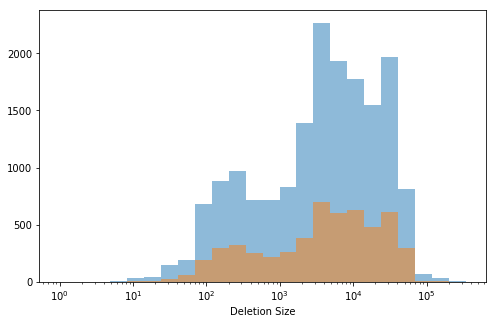

In [371]:
plt.figure(figsize=(8, 5))
base = 1.7
max_length = max([x.length for x in ihart_deletions])
min_length = min([x.length for x in ihart_deletions])
print(np.median([x.length for x in ihart_deletions]), min_length, max_length)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1
plt.hist([x.length for x in ihart_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART')
plt.hist([x.length for x in ssc_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')
plt.show()

# Compare mothers and fathers

In [372]:
mothers_to_deletions = defaultdict(list)
fathers_to_deletions = defaultdict(list)

for d in ihart_deletions:
    if d.is_mat:
        mothers_to_deletions[d.mother].append(d)
    if d.is_pat:
        fathers_to_deletions[d.father].append(d)
        
for d in ssc_deletions:
    if d.is_mat:
        mothers_to_deletions[d.mother].append(d)
    if d.is_pat:
        fathers_to_deletions[d.father].append(d)

Ttest_relResult(statistic=0.59918132019123727, pvalue=0.55695350048460535)
Ttest_relResult(statistic=-0.42092581490763131, pvalue=0.67403475717011885)
Ttest_relResult(statistic=-0.24470332493634447, pvalue=0.80685861203099807)
Ttest_relResult(statistic=0.4542992684802924, pvalue=0.6514013112864252)
2 7
Ttest_relResult(statistic=0.1476702414433162, pvalue=0.88269601813585585)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


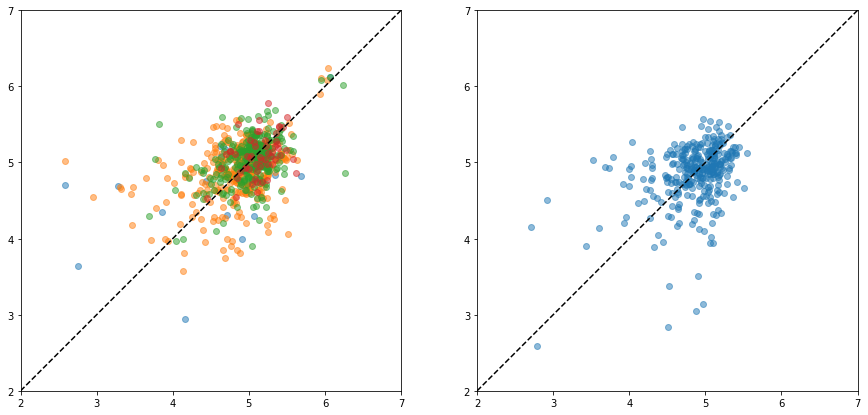

In [373]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len(fam_to_inds[v])==3]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len(fam_to_inds[v])==3]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len(fam_to_inds[v])==4]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len(fam_to_inds[v])==4]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len(fam_to_inds[v])==5]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len(fam_to_inds[v])==5]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len(fam_to_inds[v])==6]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len(fam_to_inds[v])==6]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

minvalue = math.floor(min(plt.xlim()[0], plt.ylim()[0]))
maxvalue = math.ceil(min(plt.xlim()[1], plt.ylim()[1]))
print(minvalue, maxvalue)

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.subplot(1, 2, 2)
a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ssc_families]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ssc_families]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.show()



Ttest_relResult(statistic=1.6489203079137118, pvalue=0.10699717132050723)
Ttest_relResult(statistic=-1.5452966819309732, pvalue=0.12277906951456675)
Ttest_relResult(statistic=1.1249597132144695, pvalue=0.26338207947517178)
Ttest_relResult(statistic=0.23704897699286817, pvalue=0.81857624583522415)
2 7
Ttest_relResult(statistic=0.1476702414433162, pvalue=0.88269601813585585)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


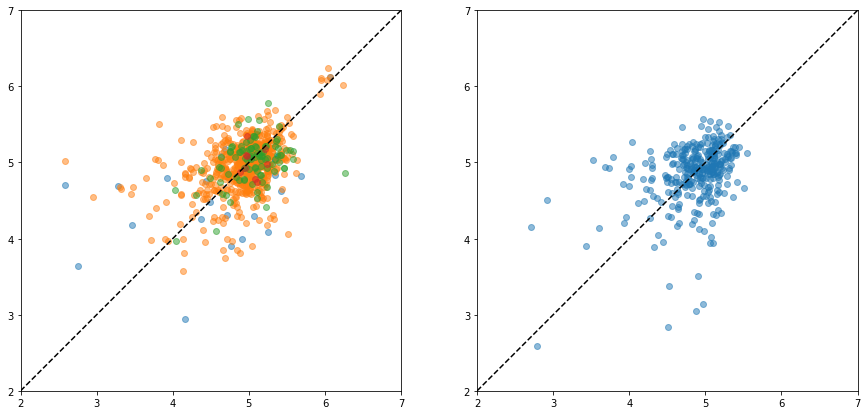

In [374]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==1]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==1]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==2]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==2]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==3]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==3]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==4]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families if len([x for x in fam_to_inds[v][2:] if child_id_to_affected[x]=='2'])==4]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

minvalue = math.floor(min(plt.xlim()[0], plt.ylim()[0]))
maxvalue = math.ceil(min(plt.xlim()[1], plt.ylim()[1]))
print(minvalue, maxvalue)

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.subplot(1, 2, 2)
a = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ssc_families]
b = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ssc_families]
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.show()



In [375]:
child_to_deletions = defaultdict(list)

for d in ihart_deletions:
    for c in d.trans:
        child_to_deletions[c].append(d)
        
for d in ssc_deletions:
    for c in d.trans:
        child_to_deletions[c].append(d)
        
ihart_children = sum([fam_to_inds[k][2:] for k in ihart_families], [])
ssc_children = sum([fam_to_inds[k][2:] for k in ssc_families], [])

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


Ttest_relResult(statistic=0.32535005335455458, pvalue=0.74495775536984554)
Ttest_relResult(statistic=-0.63753448598504647, pvalue=0.52419477892197386)
1 7
Ttest_relResult(statistic=-0.65551231682820721, pvalue=0.51260893793489837)
Ttest_relResult(statistic=0.22278241050002265, pvalue=0.82384699108650827)


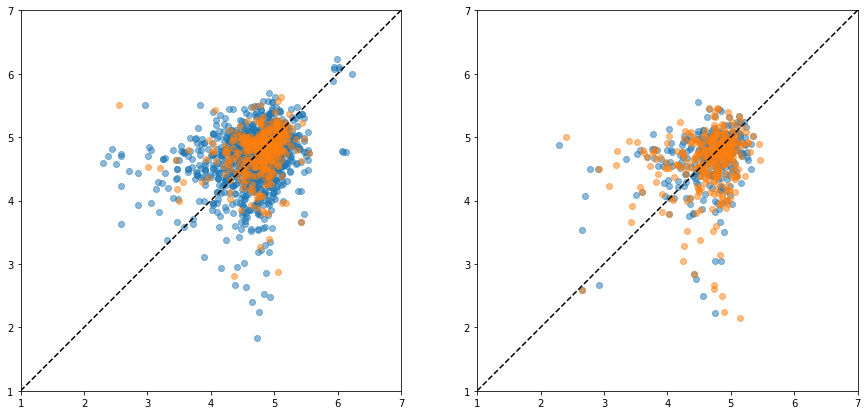

In [376]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
a = [sum([d.length for d in child_to_deletions[c] if d.is_mat]) for c in ihart_children if child_id_to_affected[c]=='2']
b = [sum([d.length for d in child_to_deletions[c] if d.is_pat]) for c in ihart_children if child_id_to_affected[c]=='2']
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in child_to_deletions[c] if d.is_mat]) for c in ihart_children if child_id_to_affected[c]=='1']
b = [sum([d.length for d in child_to_deletions[c] if d.is_pat]) for c in ihart_children if child_id_to_affected[c]=='1']
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

minvalue = math.floor(min(plt.xlim()[0], plt.ylim()[0]))
maxvalue = math.ceil(min(plt.xlim()[1], plt.ylim()[1]))
print(minvalue, maxvalue)

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.subplot(1, 2, 2)
a = [sum([d.length for d in child_to_deletions[c] if d.is_mat]) for c in ssc_children if child_id_to_affected[c]=='2']
b = [sum([d.length for d in child_to_deletions[c] if d.is_pat]) for c in ssc_children if child_id_to_affected[c]=='2']
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

a = [sum([d.length for d in child_to_deletions[c] if d.is_mat]) for c in ssc_children if child_id_to_affected[c]=='1']
b = [sum([d.length for d in child_to_deletions[c] if d.is_pat]) for c in ssc_children if child_id_to_affected[c]=='1']
plt.scatter(np.log10(a), np.log10(b), alpha=0.5)
print(scipy.stats.ttest_rel(a, b))

plt.xlim([minvalue, maxvalue])
plt.ylim([minvalue, maxvalue])
plt.plot([minvalue, maxvalue], [minvalue, maxvalue], linestyle='--', color='black')

plt.show()



Ttest_indResult(statistic=0.28757113925159927, pvalue=0.7737050578341802)


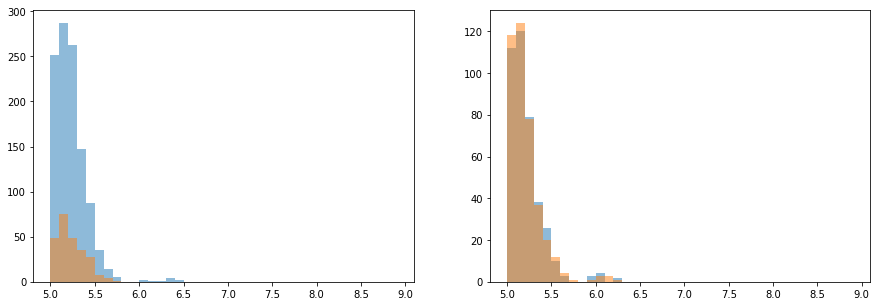

In [377]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
a = [sum([d.length for d in child_to_deletions[c]]) for c in ihart_children if child_id_to_affected[c]=='2']
b = [sum([d.length for d in child_to_deletions[c]]) for c in ihart_children if child_id_to_affected[c]=='1']
c = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]]]) for v in ihart_families]
d = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]]]) for v in ihart_families]
print(scipy.stats.ttest_ind(a, b))

bins = np.arange(5, 9, 0.1)
plt.hist(np.log10(np.asarray(a)+1), bins=bins, alpha=0.5, label='aff child')
plt.hist(np.log10(np.asarray(b)+1), bins=bins, alpha=0.5, label='unaff child')


plt.subplot(1, 2, 2)
plt.hist(np.log10(np.asarray(c)+1), bins=bins, alpha=0.5, label='mom')
plt.hist(np.log10(np.asarray(d)+1), bins=bins, alpha=0.5, label='dad')

plt.show()

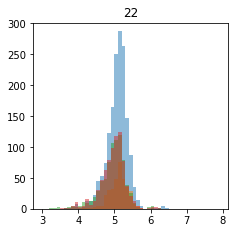

In [378]:
plt.figure(figsize=(15, 15))

for i, chrom in enumerate(chroms):
    plt.subplot(5, 5, i+1)
    a = [sum([d.length for d in child_to_deletions[c] if d.chrom==chrom]) for c in ihart_children if child_id_to_affected[c]=='2']
    b = [sum([d.length for d in child_to_deletions[c] if d.chrom==chrom]) for c in ihart_children if child_id_to_affected[c]=='1']
    c = [sum([d.length for d in mothers_to_deletions[fam_to_inds[v][0]] if d.chrom==chrom]) for v in ihart_families]
    d = [sum([d.length for d in fathers_to_deletions[fam_to_inds[v][1]] if d.chrom==chrom]) for v in ihart_families]

    bins = np.arange(3, 8, 0.1)
    plt.hist(np.log10(np.asarray(a)+1), bins=bins, alpha=0.5, label='aff child')
    plt.hist(np.log10(np.asarray(b)+1), bins=bins, alpha=0.5, label='unaff child')
    plt.hist(np.log10(np.asarray(c)+1), bins=bins, alpha=0.5, label='mom')
    plt.hist(np.log10(np.asarray(d)+1), bins=bins, alpha=0.5, label='dad')
    plt.title(chrom)

plt.tight_layout()
plt.show()

In [379]:
print([d for d in ihart_deletions if d.length>pow(10, 6)])

[]


# TDT

In [380]:
ihart_positions = sorted(set(sum([[(x.chrom, x.start_pos), (x.chrom, x.end_pos)] for x in ihart_deletions], [])), key=lambda x:(int(x[0]), x[1]))
ihart_individuals = sorted(set(sum([x.trans+x.notrans for x in ihart_deletions], [])))
ihart_pos_to_index = dict([(x, i) for i, x in enumerate(ihart_positions)])
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])

ihart_parents = sorted(set(sum([[x.mother, x.father] for x in ihart_deletions], [])))
ihart_parent_to_index = dict([(x, i) for i, x in enumerate(ihart_parents)])

parent_gen_code = {(0, 0): 0, (0, 1): 1, (1, 0): 1, (1, 1): 2, (0, 3): 3, (3, 0): 3, (3, 1): 4, (1, 3): 4, (3, 3): 5}

ihart_dm = np.zeros((len(ihart_ind_to_index), len(ihart_pos_to_index)), dtype=int)
for d in ihart_deletions:
    start_index, end_index = ihart_pos_to_index[(d.chrom, d.start_pos)], ihart_pos_to_index[(d.chrom, d.end_pos)]
    if d.is_mat and d.mother_gen in [(0, 1), (1, 0)]:
        for ind in d.trans:
            ihart_dm[ihart_ind_to_index[ind], start_index:(end_index+1)] = 1
        for ind in d.notrans:
            ihart_dm[ihart_ind_to_index[ind], start_index:(end_index+1)] = -1
    elif d.is_pat and d.father_gen in [(0, 1), (1, 0)]:
        for ind in d.trans:
            ihart_dm[ihart_ind_to_index[ind], start_index:(end_index+1)] = 1
        for ind in d.notrans:
            ihart_dm[ihart_ind_to_index[ind], start_index:(end_index+1)] = -1
        

In [381]:
ssc_positions = sorted(set(sum([[(x.chrom, x.start_pos), (x.chrom, x.end_pos)] for x in ssc_deletions], [])), key=lambda x:(int(x[0]), x[1]))
ssc_individuals = sorted(set(sum([x.trans+x.notrans for x in ssc_deletions], [])))
ssc_pos_to_index = dict([(x, i) for i, x in enumerate(ssc_positions)])
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

ssc_dm = np.zeros((len(ssc_ind_to_index), len(ssc_pos_to_index)), dtype=int)
for d in ssc_deletions:
    start_index, end_index = ssc_pos_to_index[(d.chrom, d.start_pos)], ssc_pos_to_index[(d.chrom, d.end_pos)]
    if d.is_mat and d.mother_gen in [(0, 1), (1, 0)]:
        for ind in d.trans:
            ssc_dm[ssc_ind_to_index[ind], start_index:(end_index+1)] = 1
        for ind in d.notrans:
            ssc_dm[ssc_ind_to_index[ind], start_index:(end_index+1)] = -1
    elif d.is_pat and d.father_gen in [(0, 1), (1, 0)]:
        for ind in d.trans:
            ssc_dm[ssc_ind_to_index[ind], start_index:(end_index+1)] = 1
        for ind in d.notrans:
            ssc_dm[ssc_ind_to_index[ind], start_index:(end_index+1)] = -1
        
        

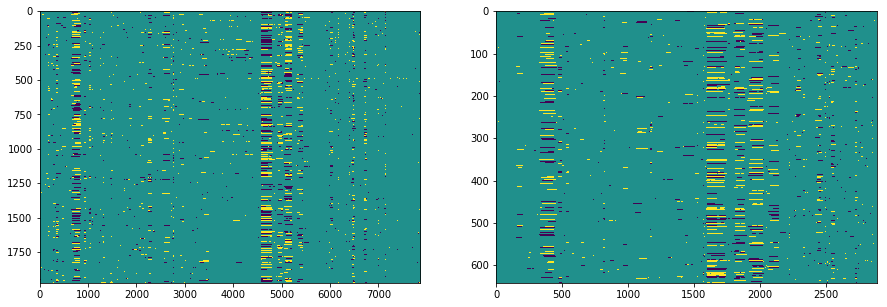

In [382]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(ihart_dm, aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(ssc_dm, aspect='auto')
plt.show()

In [383]:
from scipy.stats import fisher_exact, chi2_contingency

ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2']
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1']
ihart_contingency = np.zeros((len(ihart_positions), 2, 2), dtype=int)

ihart_contingency[:, 0, 0] = np.sum(ihart_dm[ihart_affected_indices, :]==1, axis=0)
ihart_contingency[:, 0, 1] = np.sum(ihart_dm[ihart_affected_indices, :]==-1, axis=0)
ihart_contingency[:, 1, 0] = np.sum(ihart_dm[ihart_unaffected_indices, :]==1, axis=0)
ihart_contingency[:, 1, 1] = np.sum(ihart_dm[ihart_unaffected_indices, :]==-1, axis=0)

ihart_num_tests = 0
ihart_p_values = np.ones((len(ihart_positions),))
for i in range(len(ihart_positions)):
    dc = ihart_contingency[i]

    if np.all(dc>5):
        ihart_p_values[i] = chi2_contingency(dc, correction=False)[1]
        ihart_num_tests += 1
    else:
        ihart_p_values[i] = fisher_exact(dc)[1]
        ihart_num_tests += 1
print(ihart_num_tests)

7861


In [384]:
from scipy.stats import fisher_exact, chi2_contingency

ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2']
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1']
ssc_contingency = np.zeros((len(ssc_positions), 2, 2), dtype=int)

ssc_contingency[:, 0, 0] = np.sum(ssc_dm[ssc_affected_indices, :]==1, axis=0)
ssc_contingency[:, 0, 1] = np.sum(ssc_dm[ssc_affected_indices, :]==-1, axis=0)
ssc_contingency[:, 1, 0] = np.sum(ssc_dm[ssc_unaffected_indices, :]==1, axis=0)
ssc_contingency[:, 1, 1] = np.sum(ssc_dm[ssc_unaffected_indices, :]==-1, axis=0)

ssc_num_tests = 0
ssc_p_values = np.ones((len(ssc_positions),))
for i in range(len(ssc_positions)):
    dc = ssc_contingency[i]

    if np.all(dc>5):
        ssc_p_values[i] = chi2_contingency(dc, correction=False)[1]
        ssc_num_tests += 1
    else:
        ssc_p_values[i] = fisher_exact(dc)[1]
        ssc_num_tests += 1
print(ssc_num_tests)

2886


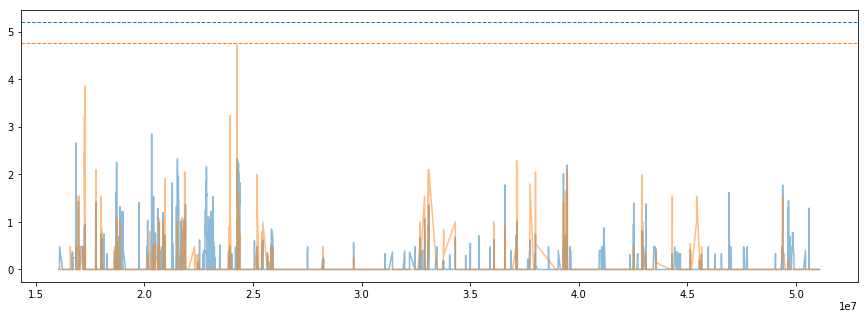

In [385]:
plt.figure(figsize=(15, 5))

p = plt.plot([p[1] for p in ihart_positions], -np.log10(ihart_p_values), alpha=0.5)
plt.axhline(y=-np.log10(0.05/ihart_num_tests), linewidth=1, linestyle='--', color=p[0].get_color())

p = plt.plot([p[1] for p in ssc_positions], -np.log10(ssc_p_values), alpha=0.5)
plt.axhline(y=-np.log10(0.05/ssc_num_tests), linewidth=1, linestyle='--', color=p[0].get_color())

plt.show()

In [392]:
Interval = namedtuple('Deletion', ['chrom', 'start_pos', 'end_pos', 'length'])

def check_overlap(d1, d2):
    if d1.chrom == d2.chrom:
        if d1.end_pos < d2.start_pos or d2.end_pos < d1.start_pos:
            return False
        elif d1.start_pos <= d2.start_pos and d1.end_pos >= d2.end_pos:
            return d2.length/d1.length >= 0.5
        elif d2.start_pos <= d1.start_pos and d2.end_pos >= d1.end_pos:
            return d1.length/d2.length >= 0.5
        elif d2.start_pos < d1.end_pos:
            overlap = d1.end_pos - d2.start_pos + 1
            return overlap/d1.length >= 0.5 or overlap/d2.length >= 0.5
        elif d1.start_pos < d2.end_pos:
            overlap = d2.end_pos - d1.start_pos + 1
            return overlap/d1.length >= 0.5 or overlap/d2.length >= 0.5
    return False

ihart_unique_deletions = dict()
for i, d in enumerate(ihart_deletions):
    added = False
    for k, v in ihart_unique_deletions.items():
        if check_overlap(d, k):
            v.append(d)
            added = True
            break
    if not added:
        ihart_unique_deletions[Interval(d.chrom, d.start_pos, d.end_pos, d.length)] = [d]
            
        
print(len(ihart_unique_deletions))

ssc_unique_deletions = dict()
for i, d in enumerate(ssc_deletions):
    added = False
    for k, v in ssc_unique_deletions.items():
        if check_overlap(d, k):
            v.append(d)
            added = True
            break
    if not added:
        ssc_unique_deletions[Interval(d.chrom, d.start_pos, d.end_pos, d.length)] = [d]
            
        
print(len(ssc_unique_deletions))

combined_unique_deletions = dict()
for d in ihart_deletions+ssc_deletions:
    added = False
    for k, v in combined_unique_deletions.items():
        if check_overlap(d, k):
            v.append(d)
            added = True
            break
    if not added:
        combined_unique_deletions[Interval(d.chrom, d.start_pos, d.end_pos, d.length)] = [d]
            
        
print(len(combined_unique_deletions))

1479
500
1601


In [393]:
print(len(ihart_deletions), len(ihart_unique_deletions))
ihart_intervals = sorted(ihart_unique_deletions.keys(), key=lambda x: (int(x.chrom), x.start_pos))

ihart_ud = np.zeros((len(ihart_individuals), len(ihart_intervals)))
for i, inter in enumerate(ihart_intervals):
    for d in ihart_unique_deletions[inter]:
        try:
            if d.is_mat and d.mother_gen in [(0, 1), (1, 0)]:
                for ind in d.trans:
                    ihart_ud[ihart_ind_to_index[ind], i] = 1
                for ind in d.notrans:
                    ihart_ud[ihart_ind_to_index[ind], i] = -1
            elif d.is_pat and d.father_gen in [(0, 1), (1, 0)]:
                for ind in d.trans:
                    ihart_ud[ihart_ind_to_index[ind], i] = 1
                for ind in d.notrans:
                    ihart_ud[ihart_ind_to_index[ind], i] = -1
        except:
            pass
                
print(len(ssc_deletions), len(ssc_unique_deletions))
ssc_intervals = sorted(ssc_unique_deletions.keys(), key=lambda x: (int(x.chrom), x.start_pos))

ssc_ud = np.zeros((len(ssc_individuals), len(ssc_intervals)))
for i, inter in enumerate(ssc_intervals):
    for d in ssc_unique_deletions[inter]:
        if d.is_mat and d.mother_gen in [(0, 1), (1, 0)]:
            for ind in d.trans:
                ssc_ud[ssc_ind_to_index[ind], i] = 1
            for ind in d.notrans:
                ssc_ud[ssc_ind_to_index[ind], i] = -1
        elif d.is_pat and d.father_gen in [(0, 1), (1, 0)]:
            for ind in d.trans:
                ssc_ud[ssc_ind_to_index[ind], i] = 1
            for ind in d.notrans:
                ssc_ud[ssc_ind_to_index[ind], i] = -1
                
print(len(ihart_deletions+ssc_deletions), len(combined_unique_deletions))
combined_intervals = sorted(combined_unique_deletions.keys(), key=lambda x: (int(x.chrom), x.start_pos))

combined_individuals = ihart_individuals+ssc_individuals
combined_affected_indices = [i for i, x in enumerate(combined_individuals) if child_id_to_affected[x] == '2']
combined_unaffected_indices = [i for i, x in enumerate(combined_individuals) if child_id_to_affected[x] == '1']
combined_ind_to_index = dict([(x, i) for i, x in enumerate(combined_individuals)])

combined_ud = np.zeros((len(combined_individuals), len(combined_intervals)))
for i, inter in enumerate(combined_intervals):
    for d in combined_unique_deletions[inter]:
        try:
            if d.is_mat and d.mother_gen in [(0, 1), (1, 0)]:
                for ind in d.trans:
                    combined_ud[combined_ind_to_index[ind], i] = 1
                for ind in d.notrans:
                    combined_ud[combined_ind_to_index[ind], i] = -1
            elif d.is_pat and d.father_gen in [(0, 1), (1, 0)]:
                for ind in d.trans:
                    combined_ud[combined_ind_to_index[ind], i] = 1
                for ind in d.notrans:
                    combined_ud[combined_ind_to_index[ind], i] = -1
        except:
            pass

17063 1479
5380 500
22443 1601


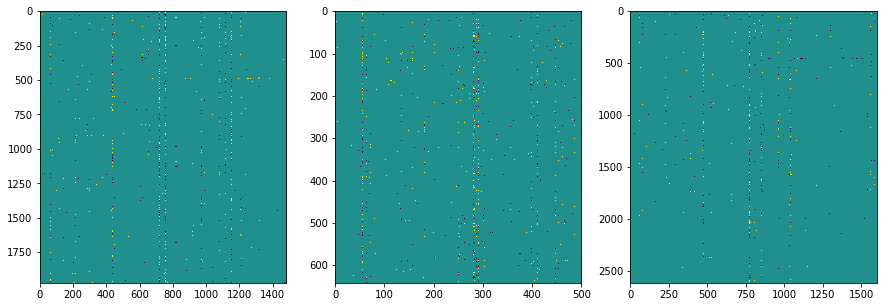

In [394]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(ihart_ud, aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(ssc_ud, aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(combined_ud, aspect='auto')
plt.show()

In [395]:
from scipy.stats import fisher_exact

ihart_int_contingency = np.zeros((len(ihart_intervals), 2, 2), dtype=int)

ihart_int_contingency[:, 0, 0] = np.sum(ihart_ud[ihart_affected_indices, :]==1, axis=0)
ihart_int_contingency[:, 0, 1] = np.sum(ihart_ud[ihart_affected_indices, :]==-1, axis=0)
ihart_int_contingency[:, 1, 0] = np.sum(ihart_ud[ihart_unaffected_indices, :]==1, axis=0)
ihart_int_contingency[:, 1, 1] = np.sum(ihart_ud[ihart_unaffected_indices, :]==-1, axis=0)

ihart_num_tests = 0
ihart_p_values = np.ones((len(ihart_intervals),))
for i in range(len(ihart_intervals)):
    dc = ihart_int_contingency[i]

    if np.all(dc>10):
        ihart_p_values[i] = chi2_contingency(dc, correction=False)[1]
        ihart_num_tests += 1
    else:
        ihart_p_values[i] = fisher_exact(dc)[1]
        ihart_num_tests += 1
print(ihart_num_tests)

ssc_int_contingency = np.zeros((len(ssc_intervals), 2, 2), dtype=int)

ssc_int_contingency[:, 0, 0] = np.sum(ssc_ud[ssc_affected_indices, :]==1, axis=0)
ssc_int_contingency[:, 0, 1] = np.sum(ssc_ud[ssc_affected_indices, :]==-1, axis=0)
ssc_int_contingency[:, 1, 0] = np.sum(ssc_ud[ssc_unaffected_indices, :]==1, axis=0)
ssc_int_contingency[:, 1, 1] = np.sum(ssc_ud[ssc_unaffected_indices, :]==-1, axis=0)

ssc_num_tests = 0
ssc_p_values = np.ones((len(ssc_intervals),))
for i in range(len(ssc_intervals)):
    dc = ssc_int_contingency[i]

    if np.all(dc>10):
        ssc_p_values[i] = chi2_contingency(dc, correction=False)[1]
        ssc_num_tests += 1
    else:
        ssc_p_values[i] = fisher_exact(dc)[1]
        ssc_num_tests += 1
print(ssc_num_tests)

combined_int_contingency = np.zeros((len(combined_intervals), 2, 2), dtype=int)

combined_int_contingency[:, 0, 0] = np.sum(combined_ud[combined_affected_indices, :]==1, axis=0)
combined_int_contingency[:, 0, 1] = np.sum(combined_ud[combined_affected_indices, :]==-1, axis=0)
combined_int_contingency[:, 1, 0] = np.sum(combined_ud[combined_unaffected_indices, :]==1, axis=0)
combined_int_contingency[:, 1, 1] = np.sum(combined_ud[combined_unaffected_indices, :]==-1, axis=0)

combined_num_tests = 0
combined_p_values = np.ones((len(combined_intervals),))
for i in range(len(combined_intervals)):
    dc = combined_int_contingency[i]

    if np.all(dc>10):
        combined_p_values[i] = chi2_contingency(dc, correction=False)[1]
        combined_num_tests += 1
    else:
        combined_p_values[i] = fisher_exact(dc)[1]
        combined_num_tests += 1
print(combined_num_tests)

1479
500
1601


4.50542132758


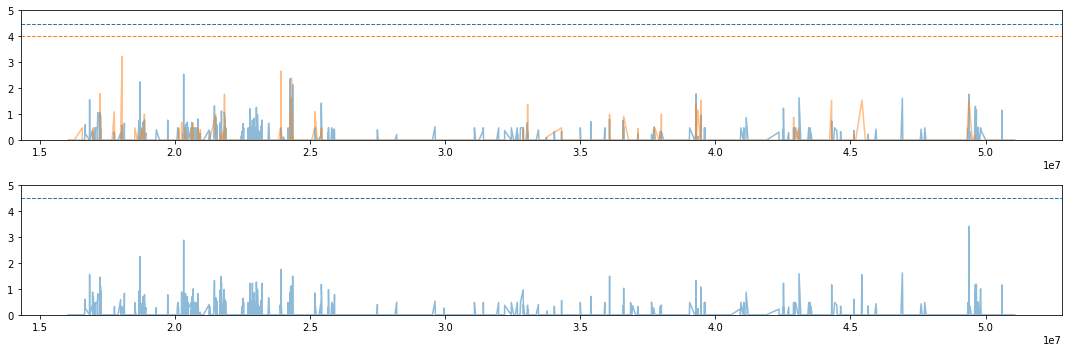

In [396]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
p = plt.plot([p.start_pos for p in ihart_intervals], -np.log10(ihart_p_values), alpha=0.5)
plt.axhline(y=-np.log10(0.05/ihart_num_tests), linewidth=1, linestyle='--', color=p[0].get_color())

p = plt.plot([p.start_pos for p in ssc_intervals], -np.log10(ssc_p_values), alpha=0.5)
plt.axhline(y=-np.log10(0.05/ssc_num_tests), linewidth=1, linestyle='--', color=p[0].get_color())
plt.ylim([0, 5])

plt.subplot(2, 1, 2)
print(-np.log10(0.05/combined_num_tests))
p = plt.plot([p.start_pos for p in combined_intervals], -np.log10(combined_p_values), alpha=0.5)
plt.axhline(y=-np.log10(0.05/combined_num_tests), linewidth=1, linestyle='--', color=p[0].get_color())
plt.ylim([0, 5])

plt.tight_layout()
plt.show()

In [391]:
indices = np.argsort(combined_p_values)[:5]
for ind in indices:
    interval = combined_intervals[ind]
    print(combined_p_values[ind], interval, '%s:%d-%d' % (interval.chrom, interval.start_pos, interval.end_pos))


0.00632183908046 Deletion(chrom='22', start_pos=49385445, end_pos=49394579, length=9135) 22:49385445-49394579
0.0119545705952 Deletion(chrom='22', start_pos=43101487, end_pos=43102358, length=872) 22:43101487-43102358
0.0167033645604 Deletion(chrom='22', start_pos=16856016, end_pos=16856289, length=274) 22:16856016-16856289
0.0184827714449 Deletion(chrom='22', start_pos=16855905, end_pos=16856464, length=560) 22:16855905-16856464
0.0206602106916 Deletion(chrom='22', start_pos=18721514, end_pos=18721586, length=73) 22:18721514-18721586


In [316]:
inter = combined_intervals[indices[2]]

In [317]:
print(inter)

Deletion(chrom='22', start_pos=24342998, end_pos=24366719, length=23722)


302
[[15  6]
 [ 1  9]]


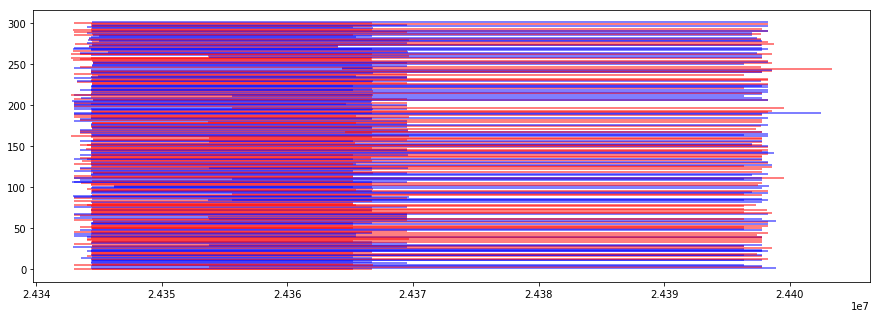

In [318]:
plt.figure(figsize=(15, 5))
for i, d in enumerate(combined_unique_deletions[inter]):
    if d.is_mat:
        color = 'red'
    else:
        color = 'blue'
    plt.hlines(i, d.start_pos, d.end_pos, color, lw=2, alpha=0.5)

print(len(combined_unique_deletions[inter]))
print(combined_int_contingency[indices[0], :, :])

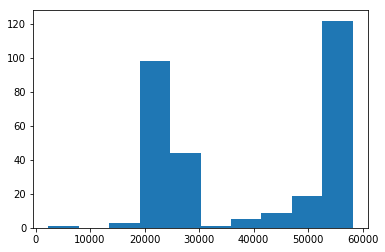

In [319]:
plt.hist([x.length for x in combined_unique_deletions[inter]])
plt.show()

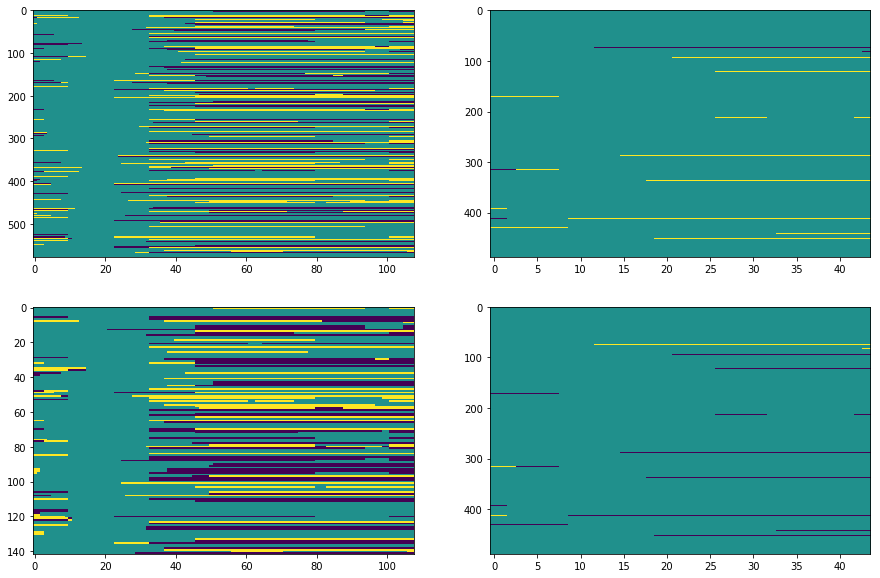

In [320]:
ihart_pos = np.asarray([x[1] for x in ihart_positions])
ssc_pos = np.asarray([x[1] for x in ssc_positions])

ihart_seg = ihart_dm[:, (ihart_pos >= inter.start_pos-10000) & (ihart_pos <= inter.end_pos+10000)]
ssc_seg = ssc_dm[:, (ssc_pos >= inter.start_pos-10000) & (ssc_pos <= inter.end_pos+10000)]

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(ihart_seg[ihart_affected_indices, :], aspect='auto')
plt.subplot(2, 2, 2)
plt.imshow(ssc_seg[ssc_affected_indices, :], aspect='auto')
plt.subplot(2, 2, 3)
plt.imshow(ihart_seg[ihart_unaffected_indices, :], aspect='auto')
plt.subplot(2, 2, 4)
plt.imshow(ssc_seg[ssc_unaffected_indices, :], aspect='auto')
plt.show()



In [321]:
start, end = inter.start_pos-10000, inter.end_pos+10000

ihart_status = np.zeros((len(ihart_individuals), end-start+1), dtype=int)
ihart_parent_status = np.zeros((len(ihart_parents), end-start+1), dtype=int)
num_included = 0
for d in ihart_deletions:
    if start < d.start_pos and d.end_pos < end:
        num_included += 1
        for ind in d.trans:
            ihart_status[ihart_ind_to_index[ind], (d.start_pos-start):(d.end_pos+1-start)] += 1
        ihart_parent_status[ihart_parent_to_index[d.mother], (d.start_pos-start):(d.end_pos+1-start)] = parent_gen_code[d.mother_gen]
        ihart_parent_status[ihart_parent_to_index[d.father], (d.start_pos-start):(d.end_pos+1-start)] = parent_gen_code[d.father_gen]   
    
    elif start < d.start_pos and d.start_pos < end:
        print('ihart cutoff')
        num_included += 1
        for ind in d.trans:
            ihart_status[ihart_ind_to_index[ind], (d.start_pos-start):max(end-start, (d.end_pos+1-start))] += 1
        ihart_parent_status[ihart_parent_to_index[d.mother], (d.start_pos-start):max(end-start, (d.end_pos+1-start))] = parent_gen_code[d.mother_gen]
        ihart_parent_status[ihart_parent_to_index[d.father], (d.start_pos-start):max(end-start, (d.end_pos+1-start))] = parent_gen_code[d.father_gen]   
     
    elif start < d.end_pos and d.end_pos < end:
        print('ihart cutoff')
        num_included += 1
        for ind in d.trans:
            ihart_status[ihart_ind_to_index[ind], min(0, (d.start_pos-start)):(d.end_pos+1-start)] += 1
        ihart_parent_status[ihart_parent_to_index[d.mother], min(0, (d.start_pos-start)):(d.end_pos+1-start)] = parent_gen_code[d.mother_gen]
        ihart_parent_status[ihart_parent_to_index[d.father], min(0, (d.start_pos-start)):(d.end_pos+1-start)] = parent_gen_code[d.father_gen]   
    
            
ssc_status = np.zeros((len(ssc_individuals), end-start+1), dtype=int)
num_included = 0
for d in ssc_deletions:
    if start < d.start_pos and d.end_pos < end:
        num_included += 1
        for ind in d.trans:
            ssc_status[ssc_ind_to_index[ind], (d.start_pos-start):(d.end_pos+1-start)] += 1
    elif start < d.start_pos and d.start_pos < end:
        print('ssc cutoff')
        num_included += 1
        for ind in d.trans:
            ssc_status[ssc_ind_to_index[ind], (d.start_pos-start):max(end-start, (d.end_pos+1-start))] += 1
    elif start < d.end_pos and d.end_pos < end:
        print('ssc cutoff')
        num_included += 1
        for ind in d.trans:
            ssc_status[ssc_ind_to_index[ind], min(0, (d.start_pos-start)):(d.end_pos+1-start)] += 1

ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff
ihart cutoff

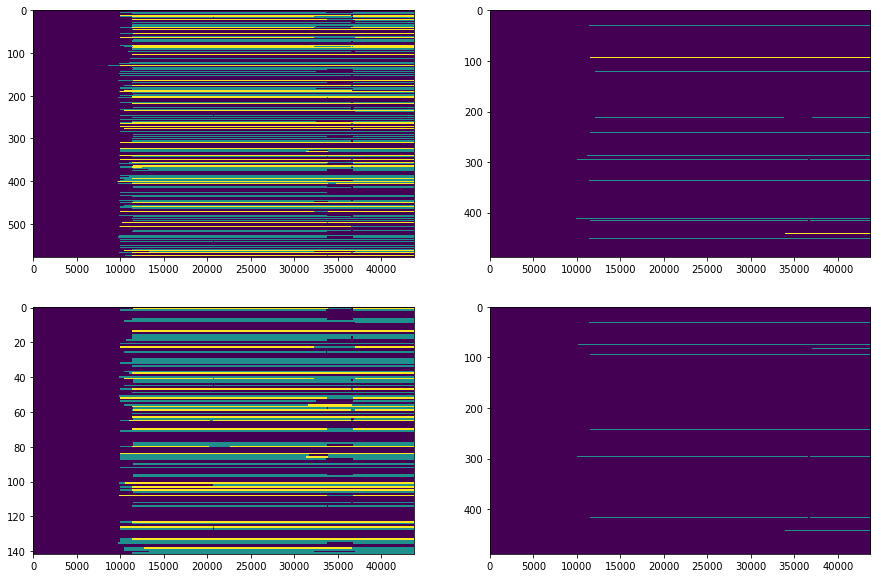

In [322]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(ihart_status[ihart_affected_indices, :], aspect='auto')
plt.subplot(2, 2, 2)
plt.imshow(ssc_status[ssc_affected_indices, :], aspect='auto')
plt.subplot(2, 2, 3)
plt.imshow(ihart_status[ihart_unaffected_indices, :], aspect='auto')
plt.subplot(2, 2, 4)
plt.imshow(ssc_status[ssc_unaffected_indices, :], aspect='auto')

plt.show()



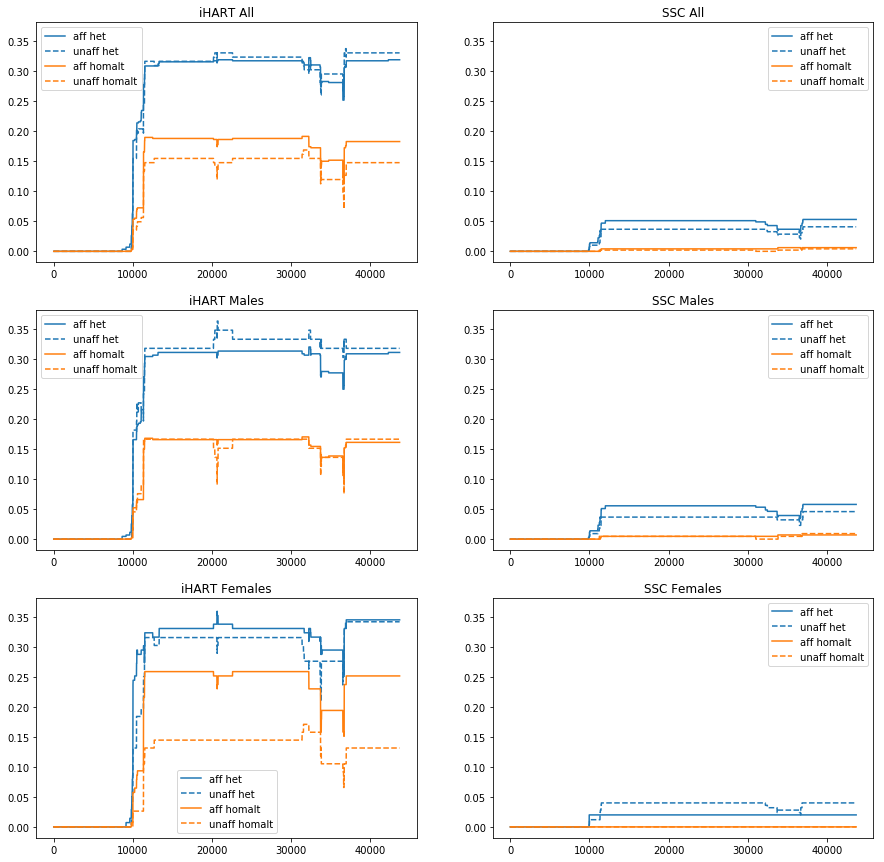

In [323]:
plt.figure(figsize=(15, 15))

ax = plt.subplot(3, 2, 1)
plt.title('iHART All')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2']
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1']
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2']
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1']

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 2, sharey=ax)
plt.title('SSC All')
p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 3, sharey=ax)
plt.title('iHART Males')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1']
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1']
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1']
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1']

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 4, sharey=ax)
plt.title('SSC Males')
p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 5, sharey=ax)
plt.title('iHART Females')
ihart_affected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2']
ihart_unaffected_indices = [i for i, x in enumerate(ihart_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2']
ssc_affected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2']
ssc_unaffected_indices = [i for i, x in enumerate(ssc_individuals) if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2']

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==1, axis=0)/len(ihart_affected_indices), label='aff het')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==1, axis=0)/len(ihart_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ihart_status[ihart_affected_indices, :]==2, axis=0)/len(ihart_affected_indices), label='aff homalt')
plt.plot(np.sum(ihart_status[ihart_unaffected_indices, :]==2, axis=0)/len(ihart_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()

plt.subplot(3, 2, 6, sharey=ax)
plt.title('SSC Females')
p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==1, axis=0)/len(ssc_affected_indices), label='aff het')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==1, axis=0)/len(ssc_unaffected_indices), label='unaff het', linestyle='--', color=p[0].get_color())

p = plt.plot(np.sum(ssc_status[ssc_affected_indices, :]==2, axis=0)/len(ssc_affected_indices), label='aff homalt')
plt.plot(np.sum(ssc_status[ssc_unaffected_indices, :]==2, axis=0)/len(ssc_unaffected_indices), label='unaff homalt', linestyle='--', color=p[0].get_color())
plt.legend()


plt.show()

In [149]:
print(start, end)

24334083 24405078


In [207]:
print(start, end)

24281608 24302263


In [104]:
chrom = '22'
data_dir = '../split_gen_ihart'

# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# use only "cleaned" variants - must be SNPs
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]

from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1004649


In [324]:
indices = (snp_positions >= start) & (snp_positions <= end)
gen = whole_chrom[:, indices].A
gen_snp_positions = snp_positions[indices]

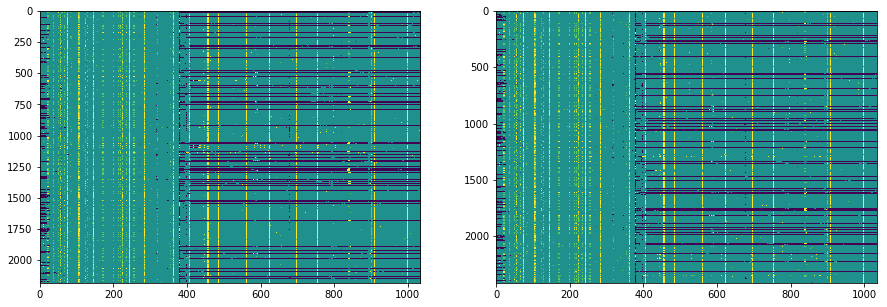

In [325]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(gen[[(s in child_id_to_affected) and (child_id_to_affected[s]=='2') for s in sample_ids], :], aspect='auto')

plt.subplot(1, 2, 2)
plt.imshow(gen[[(s in child_id_to_affected) and (child_id_to_affected[s]=='1') for s in sample_ids], :], aspect='auto')
plt.show()

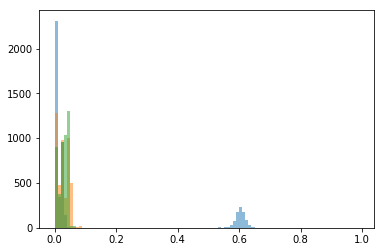

In [326]:
bins = np.arange(0, 1, 0.01)
plt.hist(np.sum(gen<0, axis=1)/gen.shape[1], bins=bins, alpha=0.5)
plt.hist(np.sum(gen==1, axis=1)/gen.shape[1], bins=bins, alpha=0.5)
plt.hist(np.sum(gen==2, axis=1)/gen.shape[1], bins=bins, alpha=0.5)

plt.show()

In [327]:
double_del = np.where(np.sum(gen<0, axis=1)/gen.shape[1]>0.2)[0]
double_del_children = [x for x in double_del if sample_ids[x] in ihart_individuals]
print(len(double_del), len(double_del_children)/len(ihart_individuals))

845 0.20665742024965325


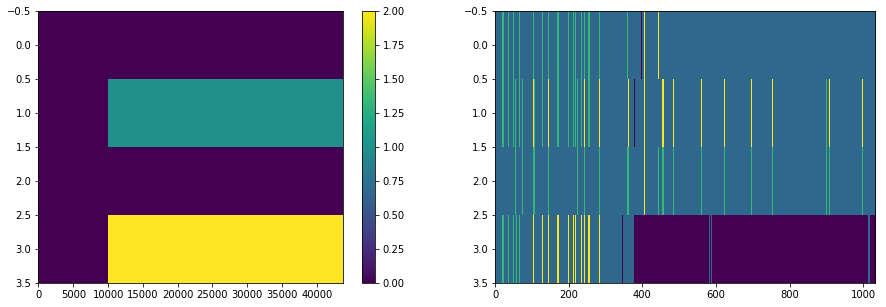

In [328]:
import random
famkey = random.choice(list(ihart_families))
inds = fam_to_inds[famkey]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
indices = [ihart_ind_to_index[x] for x in inds[2:]]
par_indices = [ihart_parent_to_index[x] for x in inds[:2]]
plt.imshow(np.vstack((ihart_parent_status[par_indices, :], ihart_status[indices, :])), aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
indices = [sample_id_to_index[x] for x in inds]
plt.imshow(gen[indices, :], aspect='auto', vmin=-1, vmax=2)

plt.show()

In [323]:
print(ihart_status.shape)

(2143, 70996)


In [324]:
print(len(ihart_individuals))

2143
